<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px"> Objective</h2>

#### Aim : To determine the sentiment of a given review. (Negative/ Neutral/ Positive)
---
#### ML Task : Supervised Learning Multi-Class Text Classification
---
#### Performance metrics : Accuracy, Confusion matrix
---


<a id="2"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">2. Data collection</h2>

### Amazon Fine Food Reviews
#### Source : https://www.kaggle.com/snap/amazon-fine-food-reviews

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Description</h2>
<p style="font-size: 14px; background-color: lightgray; padding: 10px">
    This dataset consists of reviews of fine foods from amazon. <br>
    The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.<br><br>
Reviews include product and user information, ratings, and a plain text review.
It also includes reviews from all other Amazon categories.<br><br>
   <b>Data includes :</b><br>
   - Reviews from Oct 1999 - Oct 2012<br>
   - 568,454 reviews<br>
   - 256,059 users<br>
   - 74,258 products<br><br>
<b> Attributes :</b><br>
   - <b>ProductId</b> : Unique identifier for the product<br>
   - <b>UserId</b> : Unqiue identifier for the user<br>
   - <b>ProfileName</b> : Name of customer<br>
   - <b>HelpfulnessNumerator</b> : Number of users who found the review helpful<br>
   - <b>HelpfulnessDenominator</b> : Number of users who indicated whether they found the review helpful or not<br>
   - <b>Score</b> : Rating between 1 and 5<br>
   - <b>Time</b> : Timestamp for the review<br>
   - <b>Summary</b> : Brief summary of the review<br>
   - <b>Text</b> : Review text
  
</p>

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , LSTM , Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

import pickle

<a id="3"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">3. Data Preparation</h2>

### Load data

In [5]:
data = pd.read_csv("Reviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.shape

(568454, 10)

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Data cleaning</h2>

## Handling missing values

In [7]:
# Check null values
data.isna().sum().to_frame(name='# of missing values')

,# of missing values
Id,0
ProductId,0
UserId,0
ProfileName,26
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,27
Text,0


### Remove rows which are having null values

In [8]:
total_rows =  data.shape[0]
data.dropna(how='any',inplace=True)
remaining_rows= data.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)

print(f"\nPercentage of data removed:{np.round((removed_rows/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((remaining_rows/total_rows)*100,2)}%")

No. of rows removed : 53

Percentage of data removed:0.01%
Percentage of data remaining:99.99%


### Remove duplicate rows

In [9]:
a =  data.shape[0]
data.drop_duplicates(inplace=True, subset=['Score','Text'])
b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed: {np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining: {np.round((b/total_rows)*100,2)}%")

No. of rows removed : 174745

Percentage of data removed: 30.74%
Percentage of data remaining: 69.25%


### Remove outliers

In [10]:
a =  data.shape[0]

idx = data[data["HelpfulnessNumerator"]>data["HelpfulnessDenominator"]].index
data.drop(index=idx, inplace=True)

b = data.shape[0]

print("No. of rows removed :", a-b)

print(f"\nPercentage of data removed:{np.round(((a-b)/total_rows)*100,2)}%")
print(f"Percentage of data remaining:{np.round((b/total_rows)*100,2)}%")

No. of rows removed : 2

Percentage of data removed:0.0%
Percentage of data remaining:69.25%


### Create target column using Score

In [11]:
## `Score` > 3 : "Positive" 
## `Score` == 3 : "Neutral"
## `Score` < 3 : "Negative"

def create_target(x):
    
    return "Positive" if x>3 else "Negative" if x<3 else "Neutral"

data.loc[:, 'target'] = data.Score.apply(create_target)

In [12]:
# target column 
data[['Score', 'target']].sample(5)

,Score,target
90817,5,Positive
277734,5,Positive
515920,1,Negative
101325,5,Positive
512666,1,Negative


<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Handling class imbalance</h2>

### Target distribution (Before)

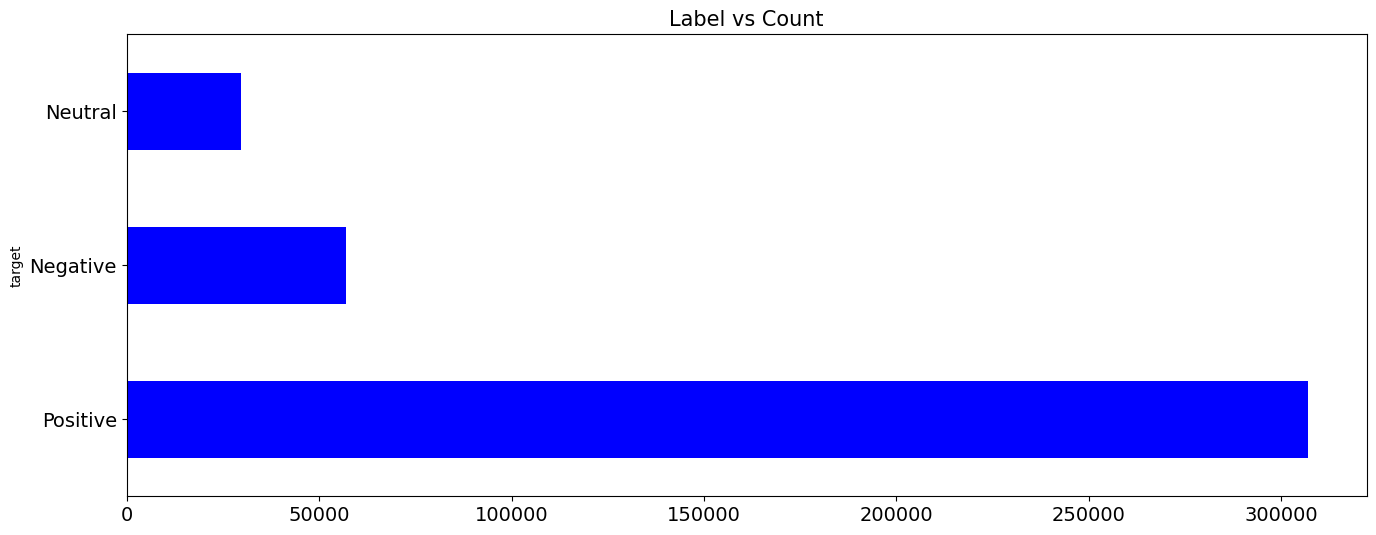

In [13]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

### Down sampling (remove some positive and negative reviews)

In [14]:
neutral = data.loc[data.target=="Neutral"] # 29770 reviews

positive = data.loc[data.target=="Positive"].sample(50000)

negative = data.loc[data.target=="Negative"].sample(50000)

data = pd.concat([positive, negative, neutral])
data.shape

(129770, 11)

### Target distribution (after)

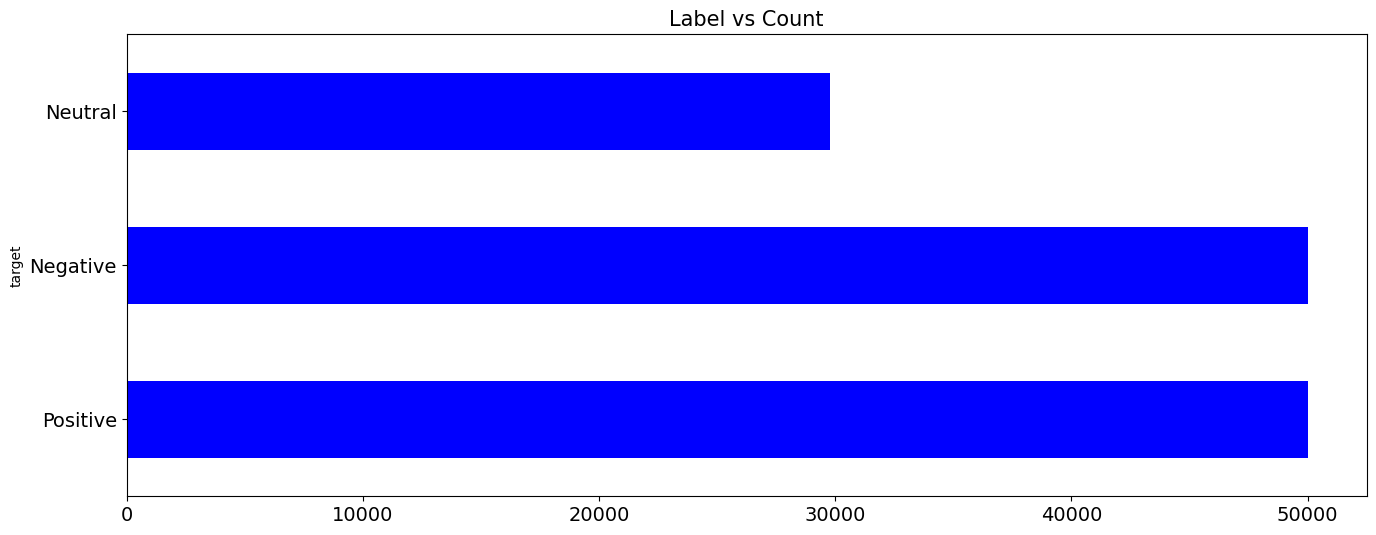

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))

vc = data.target.value_counts()
vc.plot.barh(color="blue",fontsize=14,ax=ax)
ax.set_title("Label vs Count", fontsize=15)
plt.show()

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Data Pre-processing</h2>

### Stop words

In [16]:
# stopwords
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word)

final_stopwords = total_stopwords - negative_stop_words

# 
final_stopwords.add("one")
print(final_stopwords)

{'does', 'were', 'do', 'am', 'hasn', 'wasn', 'was', 'when', 'as', 't', 'up', 'they', 'd', 'both', 'me', 'did', 'doesn', "that'll", 'ours', 'what', 'over', 'only', 'my', 'whom', 'with', 'there', 'isn', 'mightn', 'needn', 'it', 'an', 'itself', 'if', 'down', 'or', 'couldn', 'hers', 'themselves', 'your', 'on', 'himself', 'those', 'o', 'won', 'about', 'him', 'so', 'a', 'i', 'once', 'her', 'from', 'into', 'been', 'just', 'to', 'you', 'most', 'shouldn', "you're", 'which', 'ma', 'them', 'their', 'y', 'weren', 'has', 'our', 'theirs', 'yourself', 'who', 'at', 'where', 'while', 'is', 'more', 'all', 'its', 'why', 'above', 'we', 'shan', 'll', "you've", 'few', 's', "she's", 'then', 'have', 'by', 'should', 'that', 'aren', 'can', 'these', 'the', 'wouldn', "it's", 'because', 'how', 'mustn', 'of', "you'll", 'ain', 'herself', 'under', 'had', 'same', 'in', 'out', 're', 'having', 'didn', 'be', 'and', 'between', 'again', 'will', 'yours', 've', 'his', 'doing', 'off', 'through', 'myself', 'being', 'don', "sho

### Remove unwanted words from reviews
#### Ex. html tags, punctuation, stop words, etc..

In [17]:
#stemming object
stemmer = PorterStemmer()

# ---------------------------------------------
HTMLTAGS = re.compile('<.*?>')
table = str.maketrans(dict.fromkeys(string.punctuation))
remove_digits = str.maketrans('', '', string.digits)
MULTIPLE_WHITESPACE = re.compile(r"\s+")
# ---------------------------------------------

In [18]:
def preprocessor(review):
    # remove html tags
    review = HTMLTAGS.sub(r'', review)

    # remove puncutuation
    review = review.translate(table)
    
    # remove digits
    review = review.translate(remove_digits)
    
    # lower case all letters
    review = review.lower()
    
    # replace multiple white spaces with single space
    review = MULTIPLE_WHITESPACE.sub(" ", review).strip()
    
    # remove stop words
    review = [word for word in review.split()
              if word not in final_stopwords]
    
    # stemming
    review = ' '.join([stemmer.stem(word) for word in review])
    
    return review

In [19]:
print("Before preprocessing : ")
data.Text.iloc[6]

Before preprocessing : 


"I eat sunflower seeds all the time and I have since I was a little kid.  I have tried all the flavors (ranch, lime, etc.) but I am just in love with jalepeno hot salsa. It's not HOT but it has a great flavor. I paid approximately $25 for 24 bags which wasn't a bad buy when you consider that they cost $1.39 at the grocery store and $1.59 at the gas station.  I bought them online because they stopped ofering this flavor in the stores.  The seeds arrived in a timely fashion and so far have all been very fresh.  All in all I found it was a good buy for a great product"

In [20]:
# apply preprocessing function

data.Text = data.Text.apply(preprocessor) 
print("After preprocessing : ")
data.Text.iloc[6]

After preprocessing : 


'eat sunflow seed time sinc littl kid tri flavor ranch lime etc love jalepeno hot salsa not hot great flavor paid approxim bag wasnt bad buy consid cost groceri store ga station bought onlin stop ofer flavor store seed arriv time fashion far fresh found good buy great product'

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Word clouds</h2>

In [21]:
def generate_wcloud(text):
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(stopwords=stopwords, background_color='white')
    wordcloud.generate(text)
    
    plt.figure(figsize=(15,7))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation='bilinear')
    return plt.show()

### Word cloud for Positive reviews

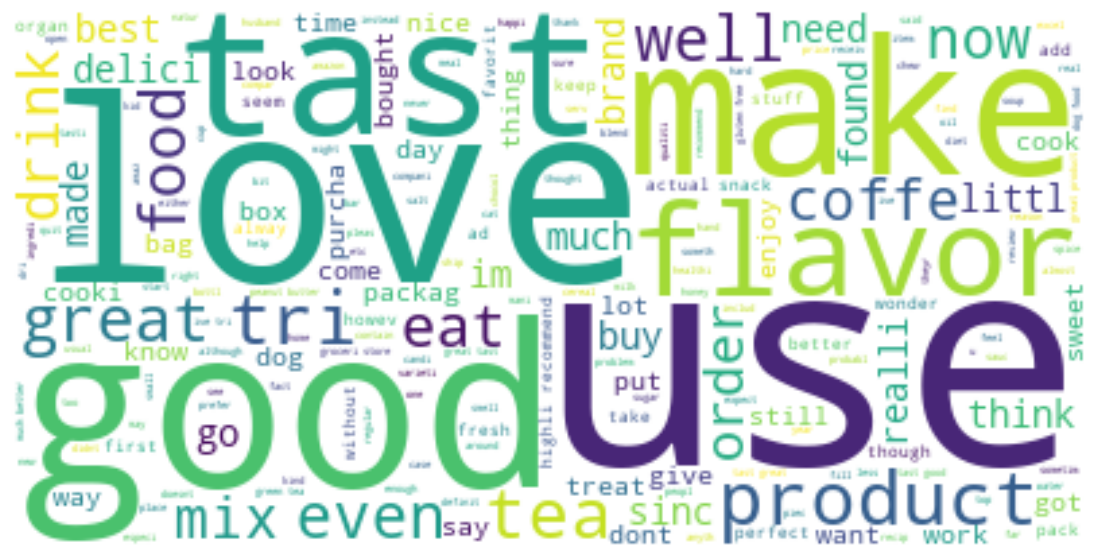

In [22]:
pos = data.loc[data.target=="Positive"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Negative reviews

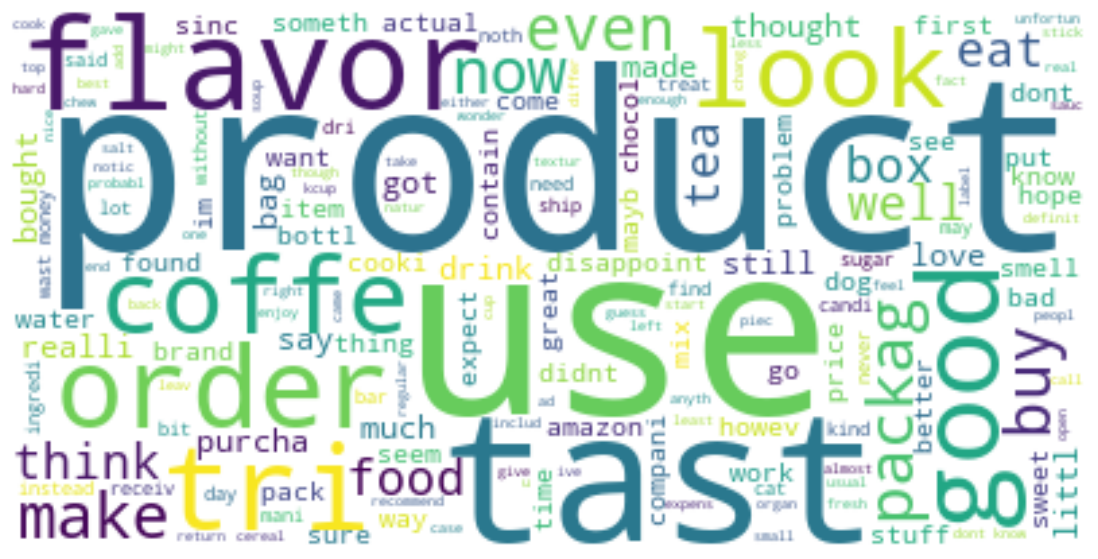

In [23]:
pos = data.loc[data.target=="Negative"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

### Word cloud for Neutral reviews

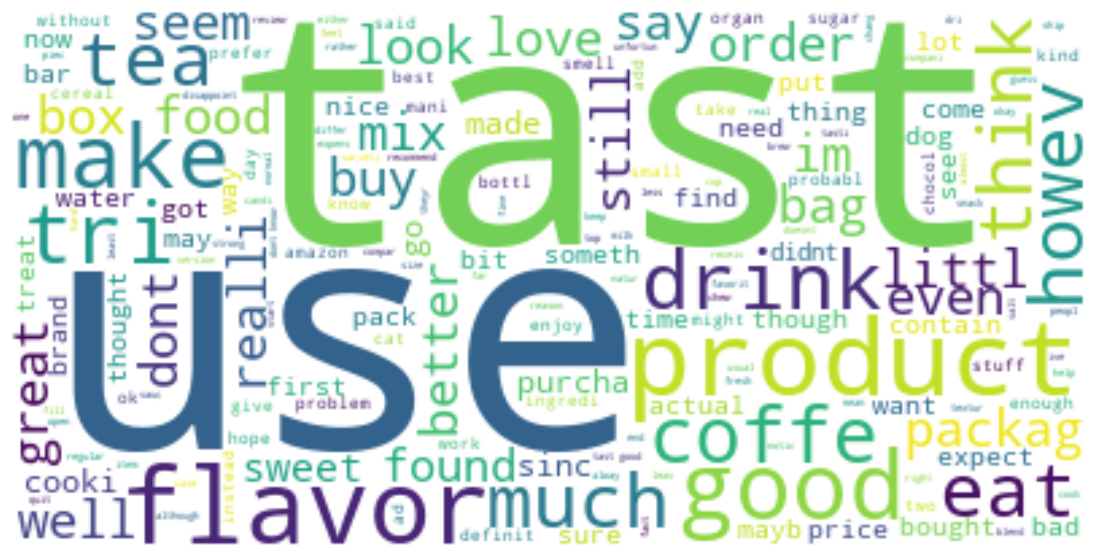

In [24]:
pos = data.loc[data.target=="Neutral"].Text
text = " ".join(review for review in pos.astype(str))

generate_wcloud(text)

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Train Test Split</h2>

#### Train set : 70% of data
#### Test set : 30% of data

In [25]:
X = data.Text
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    
    X, y, test_size=0.20, random_state=1, stratify=y)

In [26]:
X_train.shape, X_test.shape

((103816,), (25954,))

<h2 style = "font-size:25px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 5px">Vectorization</h2>

### Bag of Words Vectorizer

In [27]:
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)

# transform
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)

### TF-IDF Vectorizer

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)

###  Label Encoding

In [29]:
labelEncoder = LabelEncoder()

y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

labels = labelEncoder.classes_.tolist()
print(labels) # index-> class

['Negative', 'Neutral', 'Positive']


<a id="4"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">4. Model Training</h2>

In [30]:
### 
def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")
    print('\n',40*'-')

## Logistic Regression with BoW

In [31]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.701674115743238
Test accuracy score : 0.6911458734684441

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.7384121907991061
Test accuracy score : 0.7153425290899283

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.7663943900747476
Test accuracy score : 0.7172690144101102

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.787489404330739
Test accuracy score : 0.7061724589658627

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7930376820528627
Test accuracy score : 0.693072358788626

 ----------------------------------------


## Naive Bayes Classifier with BoW

In [32]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7119422824998074
Test accuracy score : 0.6806657933266549

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7110753641057255
Test accuracy score : 0.6822840409956076

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7109019804269091
Test accuracy score : 0.6827849271788549

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7107285967480927
Test accuracy score : 0.682977575710873

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7105263157894737
Test accuracy score : 0.6831316945364876

 ----------------------------------------


## Logistic Regression with Tf-Idf

In [33]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, max_iter=500, random_state=1)
Train accuracy score : 0.645921630577175
Test accuracy score : 0.6416352007397703

 ----------------------------------------

LogisticRegression(C=0.01, max_iter=500, random_state=1)
Train accuracy score : 0.6802708638360175
Test accuracy score : 0.6730754411651383

 ----------------------------------------

LogisticRegression(C=0.1, max_iter=500, random_state=1)
Train accuracy score : 0.732796486090776
Test accuracy score : 0.7151498805579102

 ----------------------------------------

LogisticRegression(C=1, max_iter=500, random_state=1)
Train accuracy score : 0.7653251907220467
Test accuracy score : 0.7220081682977576

 ----------------------------------------

LogisticRegression(C=10, max_iter=500, random_state=1)
Train accuracy score : 0.7873256530785235
Test accuracy score : 0.7115280881559682

 ----------------------------------------


## Naive Bayes classifier with Tf-Idf

In [34]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0)
Train accuracy score : 0.7173364413963166
Test accuracy score : 0.6806272636202512

 ----------------------------------------

MultinomialNB(alpha=0.2)
Train accuracy score : 0.7159301071125838
Test accuracy score : 0.682977575710873

 ----------------------------------------

MultinomialNB(alpha=0.6)
Train accuracy score : 0.7135990598751637
Test accuracy score : 0.683516991600524

 ----------------------------------------

MultinomialNB(alpha=0.8)
Train accuracy score : 0.7124720659628574
Test accuracy score : 0.683093164830084

 ----------------------------------------

MultinomialNB(alpha=1)
Train accuracy score : 0.7112776450643447
Test accuracy score : 0.6828234568852586

 ----------------------------------------


<a id="5"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">5. Model Evaluation</h2>

In [35]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

### Best model : Logistic Regression(C=1) with TfIdf data

In [36]:
bmodel = LogisticRegression(C=1, max_iter=500, random_state=1)
bmodel.fit(tfidf_X_train, y_train)

LogisticRegression(C=1, max_iter=500, random_state=1)

In [37]:
# predictions
y_preds_train = bmodel.predict(tfidf_X_train)
y_preds_test = bmodel.predict(tfidf_X_test)

### Accuracy

In [38]:
print(f"Train accuracy score : {accuracy_score(y_train, y_preds_train)}")
print(f"Test accuracy score : {accuracy_score(y_test, y_preds_test)}")

Train accuracy score : 0.7653251907220467
Test accuracy score : 0.7220081682977576


### Confusion Matrix

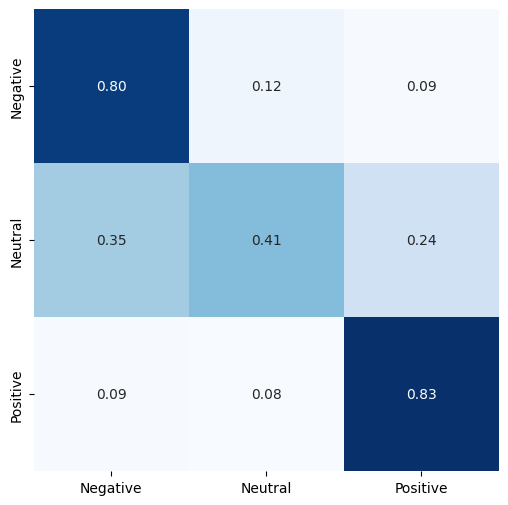

In [39]:
plot_cm(y_test, y_preds_test)

### Observations

#### - Our model is performing better on classifying positive and negative reviews.
#### - Need improvement in classifying the neutral reviews (Any suggestions??)

<a id="6"></a>
<h2 style = "font-size:30px; font-family:Garamond ; font-weight : bold; background-color: #007580; color :#fed049   ; text-align: center; border-radius: 5px 5px; padding: 10px">6. Deployment</h2>

### Save model and transformer

In [40]:
with open("transformer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)
    
with open("model.pkl", "wb") as f:
    pickle.dump(bmodel, f)

### Prediction on single review

In [41]:
# labels = ['Negative', 'Neutral', 'Positive']
def get_sentiment(review):
    # preprocessing
    x = preprocessor(review)
    #vectorization
    x = tfidf_vectorizer.transform([x])
    #prediction
    y = int(bmodel.predict(x.reshape(1,-1)))
    return labels[y]

In [42]:
# positve review
review = "This chips packet is very tasty. I highly recommend this!"
print(f"This is a {get_sentiment(review)} review!")

This is a Positive review!


In [43]:
# positve review
review = "This product is a waste of money. Don't buy this!!"
print(f"This is a {get_sentiment(review)} review!")

This is a Negative review!


## References
---

#### Theory : https://www.pyoneer.io/post/5-reasons-why-sentiment-analysis-is-important

#### CSS styling: https://www.kaggle.com/bhuvanchennoju/ancient-roots-of-agriculture-a-data-overview

#### word cloud : https://re-thought.com/creating-wordclouds-in-python/

#### Keras :  https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

## --------- ❤ The End! ❤ -----------